# End-To-End Train and Deploy Machine Learning Model on Kubernetes

Using:

 * kubeflow
 * seldon-core
 
 
Follow the main README to setup, train and deploy your model. This notebook will show how to run the Argo jobs and example prediction calls to the deployed models.

**To run this notebook you will need to install Tensorflow**
 
The example will be the MNIST handwriiten digit classification task.

![MNIST](mnist.png "MNIST Digits")

# Setup

Set kubectl to use the namespace where you installed kubeflow and seldon. In the README it is kubeflow-seldon

In [1]:
!kubectl config set-context $(kubectl config current-context) --namespace=kubeflow-seldon

Context "gke_seldon-deploy_europe-west1-b_cluster-1" modified.


# Mnist Setup
You will need Tensorflow installed to run this section.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


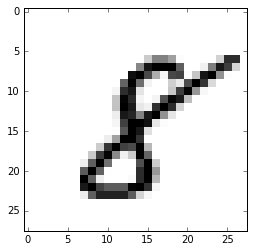

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_xs, batch_ys = mnist.train.next_batch(10)
gen_image(batch_xs[1]).show()

In [4]:
import requests
from requests.auth import HTTPBasicAuth
import commands
from random import randint,random
from proto import prediction_pb2
from proto import prediction_pb2_grpc
import grpc
import json
from visualizer import get_graph

#AMBASSADOR_API_IP=commands.getoutput("kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].ip}'")
AMBASSADOR_API_IP="localhost:8002"

def rest_request(deploymentName,request):
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=request)
    return response.json()   
    
def rest_request_auth(deploymentName,data,username,password):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload,
                auth=HTTPBasicAuth(username, password))
    print response.status_code
    return response.json()   

def grpc_request(deploymentName,data):
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [1,784],
                values = data
                )
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(AMBASSADOR_API_IP)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('seldon',deploymentName)]
    response = stub.Predict(request=request,metadata=metadata)
    print response

def send_feedback_rest(deploymentName,request,response,reward):
    feedback = {
        "request": request,
        "response": response,
        "reward": reward
    }
    ret = requests.post(
         "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/feedback",
        json=feedback)
    return ret.text


# Get predictions
**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pods -n default -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n default 8002:80
```

If the tensorflow model has not been deployed you can directly use the kubernetes manifest for it to deploy

In [4]:
!kubectl apply -f ../k8s_serving/serving_model.json

seldondeployment "mnist-classifier" deleted


#### REST Request

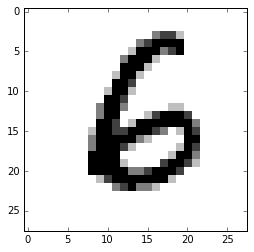

{
  "meta": {
    "puid": "8rhb6t335qm1i31q7cr782aqhk", 
    "routing": {}, 
    "tags": {}
  }, 
  "data": {
    "names": [
      "class:0", 
      "class:1", 
      "class:2", 
      "class:3", 
      "class:4", 
      "class:5", 
      "class:6", 
      "class:7", 
      "class:8", 
      "class:9"
    ], 
    "ndarray": [
      [
        0.03333333333333333, 
        0.13333333333333333, 
        0.03333333333333333, 
        0.0, 
        0.2, 
        0.26666666666666666, 
        0.1, 
        0.23333333333333334, 
        0.0, 
        0.0
      ]
    ]
  }
}


In [8]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}
predictions = rest_request("mnist-classifier",request)
print(json.dumps(predictions, indent=2))

gRPC Request

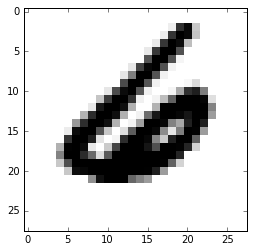

meta {
  puid: "e7ojn837fbv116c6n8leu83snk"
}
data {
  names: "class:0"
  names: "class:1"
  names: "class:2"
  names: "class:3"
  names: "class:4"
  names: "class:5"
  names: "class:6"
  names: "class:7"
  names: "class:8"
  names: "class:9"
  tensor {
    shape: 1
    shape: 10
    values: 0.000210807600524
    values: 8.3035871512e-09
    values: 0.00102185818832
    values: 4.56889210909e-07
    values: 0.000523503054865
    values: 4.08204641644e-06
    values: 0.998104572296
    values: 6.53166637221e-07
    values: 4.40969088231e-05
    values: 8.98502621567e-05
  }
}



In [7]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((784))
grpc_request("mnist-classifier",data)

# Next Steps
seldon-core can deploy complex runtime graphs. We'll illustrate two below by training a second model using scikit-learn.

In [10]:
!argo submit ../workflows/training-sk-mnist-workflow.yaml

Name:             kubeflow-train-mxfvs
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Thu Feb 22 15:40:31 +0000 (now)
Parameters:       
  version:        0.1
  github-user:    kubeflow
  github-revision: master
  docker-user:    seldonio
  push-image:     false


In [11]:
!argo list

NAME                   STATUS      AGE    DURATION
kubeflow-train-mxfvs   Running     4s     4s 
seldon-deploy-gmfcr    Succeeded   5m     2m 
kubeflow-train-g9wmj   Succeeded   20m    2m 


In [16]:
!argo submit ../workflows/serving-sk-mnist-workflow.yaml

Name:             seldon-deploy-xh84k
Namespace:        default
ServiceAccount:   default
Status:           Pending
Created:          Tue Feb 13 18:32:04 +0000 (now)
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  docker-user:    seldonio


In [17]:
!argo list

NAME                   STATUS      AGE    DURATION
seldon-deploy-xh84k    Running     15s    15s 
kubeflow-train-hxvmc   Succeeded   8m     3m 


## AB Test
 Run an AB Test between Tensorflow model and SKLearn Random Forest.
 

In [42]:
!pygmentize ../k8s_serving/ab_test_sklearn_tensorflow.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

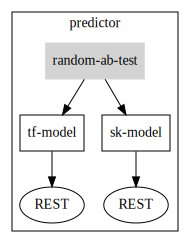

In [43]:
get_graph("../k8s_serving/ab_test_sklearn_tensorflow.json",'r')

In [20]:
!kubectl apply -f ../k8s_serving/ab_test_sklearn_tensorflow.json

seldondeployment "mnist-classifier" configured


Wait until ready (replicas == replicasAvailable)

In [21]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier replicas:1 replicasAvailable:1]]]

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


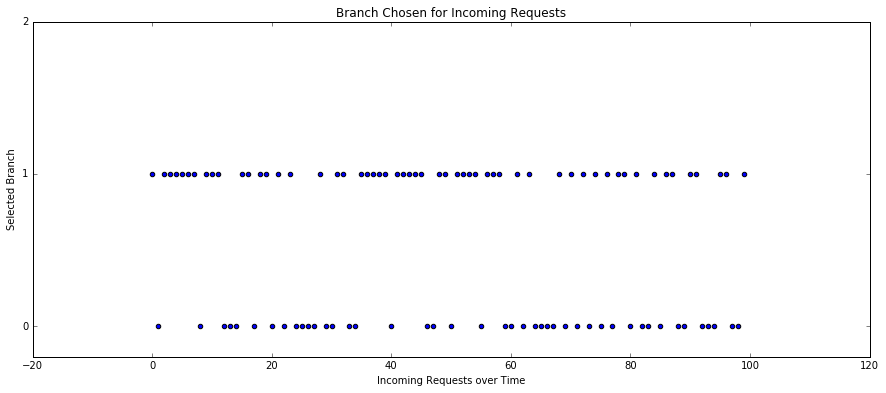

In [22]:
sz = 100
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print "{}/{}".format(idx,sz)
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("random-ab-test")
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")

## Multi-Armed Bandit
Run a e-greey multi-armed bandit to push traffic to best performing model.

In [30]:
!pygmentize ../k8s_serving/epsilon_greedy.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

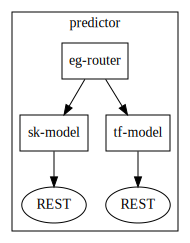

In [31]:
get_graph("../k8s_serving/epsilon_greedy.json",'r')

In [32]:
!kubectl apply -f ../k8s_serving/epsilon_greedy.json

seldondeployment "mnist-classifier" configured


Wait until ready (replicas == replicasAvailable)

In [33]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier replicas:1 replicasAvailable:1]]]

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
[3.0, 80.0]


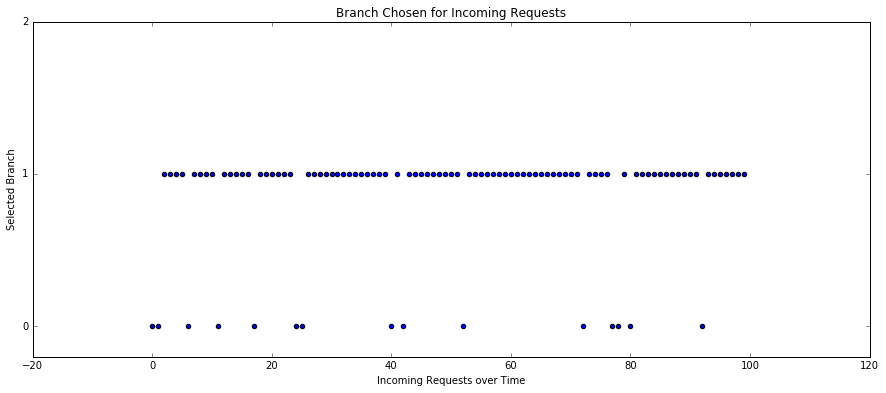

In [34]:
score = [0.0,0.0]
sz = 100
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print "{}/{}".format(idx,sz)
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("eg-router")
    proba = response["data"]["ndarray"][0]
    predicted = proba.index(max(proba))
    correct = np.argmax(batch_ys[idx])
    if predicted == correct:
        score[route] = score[route] + 1
        send_feedback_rest("mnist-classifier",request,response,reward=1)
    else:
        send_feedback_rest("mnist-classifier",request,response,reward=0)
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")
print score